In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import os
%matplotlib inline

In [44]:
class MD_based_RS:
    """
    类说明： 基于矩阵分解的推荐系统
    """
    def __init__(self,R,W,TR,TW,Parameters):
        """
        函数说明：初始化推荐系统所需参数
        参数：
            R - 训练集评分矩阵
            W - 训练集权重矩阵，消去不存在的评分的影响
            TR - 测试评分矩阵
            TW - 测试权重矩阵
            Parameters - 超参数
        """
        self.Rating_Matrix=R
        self.n_rows=Parameters['n_rows']
        self.n_cols=Parameters['n_cols']
        self.K=Parameters['K']    #潜在特征数，通常在10-100间
        self.penalty_factor=Parameters['penalty_factor']    #惩罚因子
        self.max_loops=Parameters['max_loops']
        self.epsilon=Parameters['epsilon']    #判断收敛
        
        self.Weight_Matrix=W
        self.Test_Rating_Matrix=TR
        self.Test_Weight_Matrix=TW
        
        #self.P_users;    #用户因子矩阵
        #self.Q_item;    #物品因子矩阵
        
    def RMSE(self,Rating_Matrix,Weight_Matrix):
        """
        函数说明：计算均方根误差
        参数说明：
            Rating_Matrix - 上一轮评分矩阵
        返回值：
            rmse - 均方根误差
        """
        
        Predict=self.P_users.dot(self.Q_item.T)
        rmse=np.sqrt((Weight_Matrix*np.asarray((Rating_Matrix-Predict))**2).sum()/(self.n_rows*self.n_cols))
        return rmse
    
    def loss(self,Rating_Matrix,Weight_Matrix):
        """
        函数说明：计算loss
        参数说明：
            Rating_Matrix - 评分矩阵
            Weight_Matrix - 权重矩阵
        返回值：
            loss - 损失
        """
        Predict=self.P_users.dot(self.Q_item.T)
        SEL=np.sum((Weight_Matrix*np.asarray(Rating_Matrix-Predict))**2)
        #正则化
        RP=0
        RQ=0
        for i in range(0,self.n_rows):
            RP+=self.penalty_factor*self.P_users[i,:].dot(self.P_users[i,:].T)
        for i in range(0,self.n_cols):
            RQ+=self.penalty_factor*self.Q_item[i,:].dot(self.Q_item[i,:].T)
        LOSS=SEL+RP+RQ
        return LOSS/(self.n_rows*self.n_cols)
    
    def iteration(self,matrix_fixed):
        """
        函数说明：每一次迭代更新因子矩阵
        参数说明：
            matrix_fixed - 需要更新的因子矩阵
        返回值：
            solve_vecs - 法方程组得出的解
        """
        tic=time.time
        if matrix_fixed=="P_users":
            solve_vecs=np.linalg.solve(np.dot(self.P_users.T,self.P_users)+
                                      self.penalty_factor*np.eye(self.K),
                                     np.dot(self.P_users.T,self.Rating_Matrix)).T
        else:
            solve_vecs=np.linalg.solve(np.dot(self.Q_item.T,self.Q_item)+
                                       self.penalty_factor*np.eye(self.K),
                                      np.dot(self.Q_item.T,self.Rating_Matrix.T)).T
        #print('更新 {} 成功，用时:{:0.5f}s'.format(matrix_fixed,time.time()-tic))
        return solve_vecs
    
    def draw(self):
        """
        函数说明：loss和rmse随迭代次数的变化
        """
        loops=self.max_loops
        plt.plot(np.arange(0,loops-1,1),self.train_Rmse[0:loops-1],label='Train_RMSE')
        plt.plot(np.arange(0, loops - 1, 1), self.test_Rmse[0:loops - 1], label='Test_RMSE')
        plt.xlabel('loops')
        plt.ylabel('RMSE')
        plt.title('RMSE In Train And Test')
        plt.legend()
        plt.show()
        
        loops=self.max_loops
        plt.plot(np.arange(0, loops - 1, 1), self.test_Loss[0:loops - 1], label='Test_Loss')
        plt.plot(np.arange(0, loops - 1, 1), self.train_Loss[0:loops - 1], label='Train_Loss')
        plt.xlabel('loops')
        plt.ylabel('loss')
        plt.title('Loss In Train And Test')
        plt.legend()
        plt.show()
        
    def train(self):
        """
        函数说明：训练模型
        """
        tic=time.time()
        self.train_Rmse=[]
        self.train_Loss=[]
        self.test_Rmse=[]
        self.test_Loss=[]
        self.P_users=np.random.normal(size=(self.n_rows,self.K))
        self.Q_item=np.random.normal(size=(self.n_cols,self.K))
        count=0
        rmse=1
        
        while count<self.max_loops:
            if rmse<self.epsilon:
                break
            else:
                print("第{}次更新用户因子矩阵".format(count))
                self.P_users=self.iteration('Q_item')
                print("第{}次更新物品因子矩阵".format(count))
                self.Q_item=self.iteration("P_users")
                
                #记录RMSE和LOSS
                train_rmse=self.RMSE(self.Rating_Matrix,self.Weight_Matrix)
                train_loss=self.loss(self.Rating_Matrix,self.Weight_Matrix)
                test_rmse=self.RMSE(self.Test_Rating_Matrix,Test_Weight_Matrix)
                test_loss=self.loss(self.Test_Rating_Matrix,self.Test_Weight_Matrix)
                
                self.train_Rmse.append(train_rmse)
                self.train_Loss.append(train_loss)
                self.test_Rmse.append(test_rmse)
                self.test_Loss.append(test_loss)
                print(train_rmse)
                print('第{}次循环 - Train: RMSE:{:0.2f},Loss:{:0.2f}; Test: RMSE:{:0.2f},Loss:{:0.2f}'.format(count,train_rmse,train_loss,test_rmse,test_loss))
            
                count+=1
        
        print("已收敛，总循环次数：{}，总用时：{:0.2f}秒".format(count,time.time()-tic))
    

In [45]:
def loadMovieLens(parameters,directory_path):
    """
    函数说明：导入数据集,mode==0,原始数据集；mode=1，已切分数据集
    参数说明：
        parameters - 一组超参
        directory_path - 数据集路径
    """
    tic=time.time()
    n_rows=parameters['n_rows']
    n_cols=parameters['n_cols']
    mode=parameters['mode']
    
    if mode==0:
        file_path=directory_path+'/u.data'
        Train_Rating_Matrix=np.zeros(shape=(n_rows,n_cols))
        Train_Weight_Matrix = np.zeros(shape=(n_rows, n_cols))
        Test_Rating_Matrix=np.zeros(shape=(n_rows,n_cols))
        Test_Weight_Matrix = np.zeros(shape=(n_rows, n_cols))
        origin_data=np.loadtxt(file_path)
        train,test=train_test_split(origin_data,test_size=0.2,random_state=1)
        for i in range(0,train.shape[0]):
            user_id=int(train[i][0])
            item_id=int(train[i][1])
            rating=train[i][2]
            #user_id和item_id没有0
            Train_Rating_Matrix[user_id-1,item_id-1]=rating
            if rating!=0:
                Train_Weight_Matrix[user_id - 1, item_id - 1] = 1
        for i in range(0,test.shape[0]):
            user_id=int(test[i][0])
            item_id=int(test[i][1])
            rating=test[i][2]
            Test_Rating_Matrix[user_id-1,item_id-1]=rating
            if rating!=0:
                Test_Weight_Matrix[user_id - 1, item_id - 1] = 1
        print('成功导入原始数据集，并用留出法切分。用时:{:0.2f}'.format(time.time()-tic))
        return Train_Rating_Matrix,Train_Weight_Matrix,Test_Rating_Matrix,Test_Weight_Matrix
    
    if mode==1:
        Train_Rating_Matrixs=[]
        Train_Weight_Matrixs=[]
        Test_Rating_Matrixs=[]
        Test_Weight_Matrixs=[]
        for i in range(1,6):
            Train_Rating_Matrix = np.zeros(shape=(n_rows, n_cols))
            Train_Weight_Matrix = np.zeros(shape=(n_rows, n_cols))
            Test_Rating_Matrix = np.zeros(shape=(n_rows, n_cols))
            Test_Weight_Matrix = np.zeros(shape=(n_rows, n_cols))
            train_path = directory_path + '/u{}.base'.format(i)
            test_path = directory_path + '/u{}.test'.format(i)
            train_data = np.loadtxt(train_path)
            test_data = np.loadtxt(test_path)
            for i in range(0, train_data.shape[0]):
                user_id = int(train_data[i][0])
                item_id = int(train_data[i][1])
                rating = train_data[i][2]
                #user_id和item_id没有0
                Train_Rating_Matrix[user_id - 1, item_id - 1] = rating
                if rating != 0:
                    Train_Weight_Matrix[user_id - 1, item_id - 1] = 1
            for i in range(0, test_data.shape[0]):
                user_id = int(test_data[i][0])
                item_id = int(test_data[i][1])
                rating = test_data[i][2]
                Test_Rating_Matrix[user_id - 1, item_id - 1] = rating
                if rating != 0:
                    Test_Weight_Matrix[user_id - 1, item_id - 1] = 1
            Train_Rating_Matrixs.append(Train_Rating_Matrix)
            Train_Weight_Matrixs.append(Train_Weight_Matrix)
            Test_Rating_Matrixs.append(Test_Rating_Matrix)
            Test_Weight_Matrixs.append(Test_Weight_Matrix)
        print('成功导入已切分数据集。 用时:{:0.2f}'.format(time.time()-tic))
        Data=[Train_Rating_Matrixs,Train_Weight_Matrixs,Test_Rating_Matrixs,Test_Rating_Matrixs]
        return Data
    

In [46]:
def draw(loops,dic,x_label,y_label,title):
    for m_label,li in dic.items():
        plt.plot(np.arange(0, loops - 1, 1), li[0:loops - 1], label=m_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

In [47]:

if __name__ == '__main__':

    #设置两种情况下的超参
    prefix=os.getcwd()
    dic_path=prefix+'/ml-100k'
    # Use the full dataset:u.data
    Parameters_1={
        'n_rows':943,
        'n_cols':1682,
        'mode':0,
        'K':40,
        'penalty_factor':0.1,
        'max_loops':100,
        'epsilon':0.00001
    }
    # Use the five divided dataset
    Parameters_2={
        'n_rows':943,
        'n_cols':1682,
        'mode':1,
        'K':40,
        'penalty_factor':0.1,
        'max_loops':100,
        'epsilon':0.00001
    }
        

成功导入原始数据集，并用留出法切分。用时:0.97
第0次更新用户因子矩阵
第0次更新物品因子矩阵
0.5858306766336115
Loops:0 Completed. Train: RMSE:0.59,Loss:0.36; Test: RMSE:0.33,Loss:0.13
第1次更新用户因子矩阵
第1次更新物品因子矩阵
0.508596372025944
Loops:1 Completed. Train: RMSE:0.51,Loss:0.28; Test: RMSE:0.31,Loss:0.12
第2次更新用户因子矩阵
第2次更新物品因子矩阵
0.4967048526381583
Loops:2 Completed. Train: RMSE:0.50,Loss:0.26; Test: RMSE:0.31,Loss:0.11
第3次更新用户因子矩阵
第3次更新物品因子矩阵
0.4918111222863015
Loops:3 Completed. Train: RMSE:0.49,Loss:0.26; Test: RMSE:0.31,Loss:0.11
第4次更新用户因子矩阵
第4次更新物品因子矩阵
0.4891049357281923
Loops:4 Completed. Train: RMSE:0.49,Loss:0.25; Test: RMSE:0.31,Loss:0.11
第5次更新用户因子矩阵
第5次更新物品因子矩阵
0.4873581064756784
Loops:5 Completed. Train: RMSE:0.49,Loss:0.25; Test: RMSE:0.31,Loss:0.11
第6次更新用户因子矩阵
第6次更新物品因子矩阵
0.48612063905969266
Loops:6 Completed. Train: RMSE:0.49,Loss:0.25; Test: RMSE:0.31,Loss:0.11
第7次更新用户因子矩阵
第7次更新物品因子矩阵
0.48519094917322336
Loops:7 Completed. Train: RMSE:0.49,Loss:0.25; Test: RMSE:0.31,Loss:0.11
第8次更新用户因子矩阵
第8次更新物品因子矩阵
0.48446232440752196
L

0.478336458315805
Loops:69 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.31,Loss:0.10
第70次更新用户因子矩阵
第70次更新物品因子矩阵
0.4783192246154137
Loops:70 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.31,Loss:0.10
第71次更新用户因子矩阵
第71次更新物品因子矩阵
0.4783024058410024
Loops:71 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.31,Loss:0.10
第72次更新用户因子矩阵
第72次更新物品因子矩阵
0.4782859861532928
Loops:72 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.31,Loss:0.10
第73次更新用户因子矩阵
第73次更新物品因子矩阵
0.4782699505631338
Loops:73 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.31,Loss:0.10
第74次更新用户因子矩阵
第74次更新物品因子矩阵
0.4782542848758323
Loops:74 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.31,Loss:0.10
第75次更新用户因子矩阵
第75次更新物品因子矩阵
0.478238975639833
Loops:75 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.31,Loss:0.10
第76次更新用户因子矩阵
第76次更新物品因子矩阵
0.47822401009933724
Loops:76 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.31,Loss:0.10
第77次更新用户因子矩阵
第77次更新物品因子矩阵
0.4782093761505016
Loops:77 Completed. Train: RMS

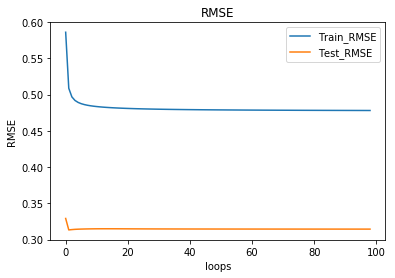

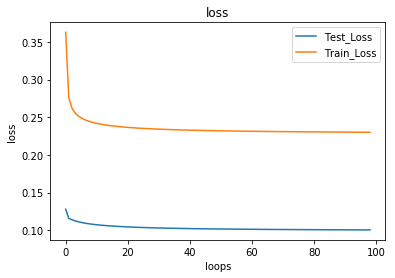

In [48]:
    #使用整个数据集训练一个模型
    Train_Rating_Matrix, Train_Weight_Matrix, Test_Rating_Matrix, Test_Weight_Matrix = loadMovieLens(Parameters_1,dic_path)
    fModel_0 = MD_based_RS(Train_Rating_Matrix, Train_Weight_Matrix, Test_Rating_Matrix, Test_Weight_Matrix, Parameters_1)
    fModel_0.train()
    fModel_0.draw()

成功导入已切分数据集。 用时:4.63
开始训练 Model_0
第0次更新用户因子矩阵
第0次更新物品因子矩阵
0.5884891777665311
Loops:0 Completed. Train: RMSE:0.59,Loss:0.37; Test: RMSE:0.22,Loss:2.34
第1次更新用户因子矩阵
第1次更新物品因子矩阵
0.501509216071015
Loops:1 Completed. Train: RMSE:0.50,Loss:0.27; Test: RMSE:0.26,Loss:2.12
第2次更新用户因子矩阵
第2次更新物品因子矩阵
0.4898523367037447
Loops:2 Completed. Train: RMSE:0.49,Loss:0.26; Test: RMSE:0.26,Loss:2.11
第3次更新用户因子矩阵
第3次更新物品因子矩阵
0.4848609511524969
Loops:3 Completed. Train: RMSE:0.48,Loss:0.25; Test: RMSE:0.26,Loss:2.11
第4次更新用户因子矩阵
第4次更新物品因子矩阵
0.48199927758503386
Loops:4 Completed. Train: RMSE:0.48,Loss:0.25; Test: RMSE:0.27,Loss:2.11
第5次更新用户因子矩阵
第5次更新物品因子矩阵
0.48011901427035253
Loops:5 Completed. Train: RMSE:0.48,Loss:0.24; Test: RMSE:0.27,Loss:2.10
第6次更新用户因子矩阵
第6次更新物品因子矩阵
0.4787789494434952
Loops:6 Completed. Train: RMSE:0.48,Loss:0.24; Test: RMSE:0.27,Loss:2.10
第7次更新用户因子矩阵
第7次更新物品因子矩阵
0.47776870287134526
Loops:7 Completed. Train: RMSE:0.48,Loss:0.24; Test: RMSE:0.27,Loss:2.10
第8次更新用户因子矩阵
第8次更新物品因子矩阵
0.47697572838

0.47038827204328765
Loops:69 Completed. Train: RMSE:0.47,Loss:0.22; Test: RMSE:0.27,Loss:2.08
第70次更新用户因子矩阵
第70次更新物品因子矩阵
0.47036912480005205
Loops:70 Completed. Train: RMSE:0.47,Loss:0.22; Test: RMSE:0.27,Loss:2.08
第71次更新用户因子矩阵
第71次更新物品因子矩阵
0.4703504831127775
Loops:71 Completed. Train: RMSE:0.47,Loss:0.22; Test: RMSE:0.27,Loss:2.08
第72次更新用户因子矩阵
第72次更新物品因子矩阵
0.47033232743606457
Loops:72 Completed. Train: RMSE:0.47,Loss:0.22; Test: RMSE:0.27,Loss:2.08
第73次更新用户因子矩阵
第73次更新物品因子矩阵
0.47031463919724786
Loops:73 Completed. Train: RMSE:0.47,Loss:0.22; Test: RMSE:0.27,Loss:2.08
第74次更新用户因子矩阵
第74次更新物品因子矩阵
0.470297400740431
Loops:74 Completed. Train: RMSE:0.47,Loss:0.22; Test: RMSE:0.27,Loss:2.08
第75次更新用户因子矩阵
第75次更新物品因子矩阵
0.47028059527399135
Loops:75 Completed. Train: RMSE:0.47,Loss:0.22; Test: RMSE:0.27,Loss:2.08
第76次更新用户因子矩阵
第76次更新物品因子矩阵
0.4702642068213364
Loops:76 Completed. Train: RMSE:0.47,Loss:0.22; Test: RMSE:0.27,Loss:2.08
第77次更新用户因子矩阵
第77次更新物品因子矩阵
0.4702482201746876
Loops:77 Completed. Train

0.47543788123594855
Loops:39 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.94
第40次更新用户因子矩阵
第40次更新物品因子矩阵
0.4753922518367593
Loops:40 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.94
第41次更新用户因子矩阵
第41次更新物品因子矩阵
0.47534851742095063
Loops:41 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.94
第42次更新用户因子矩阵
第42次更新物品因子矩阵
0.4753065630633376
Loops:42 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.94
第43次更新用户因子矩阵
第43次更新物品因子矩阵
0.4752662831405358
Loops:43 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.94
第44次更新用户因子矩阵
第44次更新物品因子矩阵
0.475227580316068
Loops:44 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.94
第45次更新用户因子矩阵
第45次更新物品因子矩阵
0.4751903646723449
Loops:45 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.94
第46次更新用户因子矩阵
第46次更新物品因子矩阵
0.47515455296452336
Loops:46 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.94
第47次更新用户因子矩阵
第47次更新物品因子矩阵
0.47512006797563405
Loops:47 Completed. Train:

0.4824318183657906
Loops:8 Completed. Train: RMSE:0.48,Loss:0.24; Test: RMSE:0.26,Loss:1.85
第9次更新用户因子矩阵
第9次更新物品因子矩阵
0.48179849598736296
Loops:9 Completed. Train: RMSE:0.48,Loss:0.24; Test: RMSE:0.26,Loss:1.85
第10次更新用户因子矩阵
第10次更新物品因子矩阵
0.48126893389266723
Loops:10 Completed. Train: RMSE:0.48,Loss:0.24; Test: RMSE:0.26,Loss:1.85
第11次更新用户因子矩阵
第11次更新物品因子矩阵
0.4808180924604379
Loops:11 Completed. Train: RMSE:0.48,Loss:0.24; Test: RMSE:0.26,Loss:1.85
第12次更新用户因子矩阵
第12次更新物品因子矩阵
0.4804281682975206
Loops:12 Completed. Train: RMSE:0.48,Loss:0.24; Test: RMSE:0.26,Loss:1.85
第13次更新用户因子矩阵
第13次更新物品因子矩阵
0.480086343673178
Loops:13 Completed. Train: RMSE:0.48,Loss:0.24; Test: RMSE:0.26,Loss:1.85
第14次更新用户因子矩阵
第14次更新物品因子矩阵
0.47978327952616623
Loops:14 Completed. Train: RMSE:0.48,Loss:0.24; Test: RMSE:0.26,Loss:1.85
第15次更新用户因子矩阵
第15次更新物品因子矩阵
0.47951206339858127
Loops:15 Completed. Train: RMSE:0.48,Loss:0.24; Test: RMSE:0.26,Loss:1.85
第16次更新用户因子矩阵
第16次更新物品因子矩阵
0.47926747751084675
Loops:16 Completed. Train: RM

第77次更新物品因子矩阵
0.47562505588365134
Loops:77 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.84
第78次更新用户因子矩阵
第78次更新物品因子矩阵
0.47560953462457206
Loops:78 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.84
第79次更新用户因子矩阵
第79次更新物品因子矩阵
0.47559437530478765
Loops:79 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.84
第80次更新用户因子矩阵
第80次更新物品因子矩阵
0.47557956589530853
Loops:80 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.84
第81次更新用户因子矩阵
第81次更新物品因子矩阵
0.4755650949265075
Loops:81 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.84
第82次更新用户因子矩阵
第82次更新物品因子矩阵
0.4755509514542403
Loops:82 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.84
第83次更新用户因子矩阵
第83次更新物品因子矩阵
0.4755371250283364
Loops:83 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.84
第84次更新用户因子矩阵
第84次更新物品因子矩阵
0.4755236056632787
Loops:84 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.84
第85次更新用户因子矩阵
第85次更新物品因子矩阵
0.4755103838109022
Loops:85 Com

0.4752298414636793
Loops:46 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.85
第47次更新用户因子矩阵
第47次更新物品因子矩阵
0.4751972468078978
Loops:47 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.85
第48次更新用户因子矩阵
第48次更新物品因子矩阵
0.4751658574246024
Loops:48 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.85
第49次更新用户因子矩阵
第49次更新物品因子矩阵
0.4751355952202029
Loops:49 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.85
第50次更新用户因子矩阵
第50次更新物品因子矩阵
0.47510638970085733
Loops:50 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.85
第51次更新用户因子矩阵
第51次更新物品因子矩阵
0.47507817706180694
Loops:51 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.85
第52次更新用户因子矩阵
第52次更新物品因子矩阵
0.4750508993902552
Loops:52 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.85
第53次更新用户因子矩阵
第53次更新物品因子矩阵
0.47502450396944224
Loops:53 Completed. Train: RMSE:0.48,Loss:0.23; Test: RMSE:0.27,Loss:1.85
第54次更新用户因子矩阵
第54次更新物品因子矩阵
0.4749989426721751
Loops:54 Completed. Train:

0.4748217627845657
Loops:15 Completed. Train: RMSE:0.47,Loss:0.23; Test: RMSE:0.27,Loss:1.94
第16次更新用户因子矩阵
第16次更新物品因子矩阵
0.4745895401740314
Loops:16 Completed. Train: RMSE:0.47,Loss:0.23; Test: RMSE:0.27,Loss:1.94
第17次更新用户因子矩阵
第17次更新物品因子矩阵
0.4743777561015201
Loops:17 Completed. Train: RMSE:0.47,Loss:0.23; Test: RMSE:0.27,Loss:1.94
第18次更新用户因子矩阵
第18次更新物品因子矩阵
0.47418395742743796
Loops:18 Completed. Train: RMSE:0.47,Loss:0.23; Test: RMSE:0.27,Loss:1.94
第19次更新用户因子矩阵
第19次更新物品因子矩阵
0.4740061940981748
Loops:19 Completed. Train: RMSE:0.47,Loss:0.23; Test: RMSE:0.27,Loss:1.94
第20次更新用户因子矩阵
第20次更新物品因子矩阵
0.47384285082256294
Loops:20 Completed. Train: RMSE:0.47,Loss:0.23; Test: RMSE:0.27,Loss:1.94
第21次更新用户因子矩阵
第21次更新物品因子矩阵
0.4736925344609389
Loops:21 Completed. Train: RMSE:0.47,Loss:0.23; Test: RMSE:0.27,Loss:1.94
第22次更新用户因子矩阵
第22次更新物品因子矩阵
0.4735540043378312
Loops:22 Completed. Train: RMSE:0.47,Loss:0.23; Test: RMSE:0.27,Loss:1.94
第23次更新用户因子矩阵
第23次更新物品因子矩阵
0.4734261332359196
Loops:23 Completed. Train: 

0.4711596940918144
Loops:84 Completed. Train: RMSE:0.47,Loss:0.22; Test: RMSE:0.27,Loss:1.93
第85次更新用户因子矩阵
第85次更新物品因子矩阵
0.4711479004938487
Loops:85 Completed. Train: RMSE:0.47,Loss:0.22; Test: RMSE:0.27,Loss:1.93
第86次更新用户因子矩阵
第86次更新物品因子矩阵
0.47113635977235485
Loops:86 Completed. Train: RMSE:0.47,Loss:0.22; Test: RMSE:0.27,Loss:1.93
第87次更新用户因子矩阵
第87次更新物品因子矩阵
0.4711250638650239
Loops:87 Completed. Train: RMSE:0.47,Loss:0.22; Test: RMSE:0.27,Loss:1.93
第88次更新用户因子矩阵
第88次更新物品因子矩阵
0.47111400505607676
Loops:88 Completed. Train: RMSE:0.47,Loss:0.22; Test: RMSE:0.27,Loss:1.93
第89次更新用户因子矩阵
第89次更新物品因子矩阵
0.4711031759579576
Loops:89 Completed. Train: RMSE:0.47,Loss:0.22; Test: RMSE:0.27,Loss:1.93
第90次更新用户因子矩阵
第90次更新物品因子矩阵
0.4710925694941106
Loops:90 Completed. Train: RMSE:0.47,Loss:0.22; Test: RMSE:0.27,Loss:1.93
第91次更新用户因子矩阵
第91次更新物品因子矩阵
0.4710821788827743
Loops:91 Completed. Train: RMSE:0.47,Loss:0.22; Test: RMSE:0.27,Loss:1.93
第92次更新用户因子矩阵
第92次更新物品因子矩阵
0.4710719976217287
Loops:92 Completed. Train: 

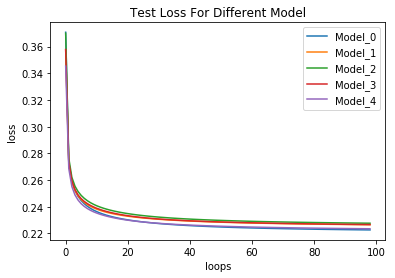

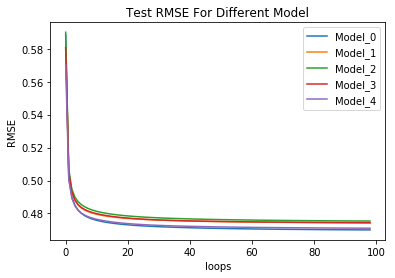

In [49]:
    #使用五个已切分的数据集训练五个不同的模型并画出曲线
    Data=loadMovieLens(Parameters_2,dic_path)
    Models=[]
    for i in range(0,5):
        tic=time.time()
        print('开始训练 Model_{}'.format(i))
        model=MD_based_RS(Data[0][i],Data[1][i],Data[2][i],Data[3][i],Parameters_2)
        model.train()
        print('Model_{} 训练完毕。用时 {:0.2f}s'.format(i,time.time()-tic))
        Models.append(model)

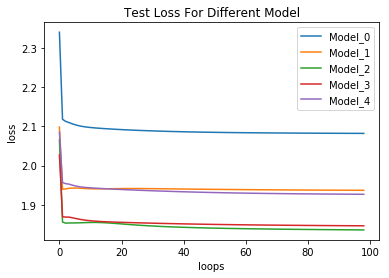

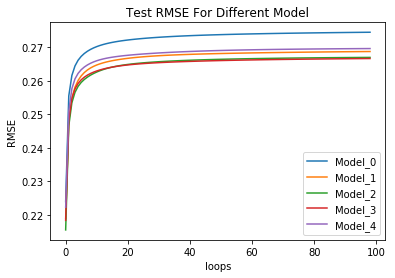

In [50]:
    #不同切分集的模型效果（loss）
    dic={'Model_0':Models[0].test_Loss,
         'Model_1': Models[1].test_Loss,
         'Model_2': Models[2].test_Loss,
         'Model_3': Models[3].test_Loss,
         'Model_4': Models[4].test_Loss,}
    draw(Parameters_2['max_loops'],dic,'loops','loss','Test Loss For Different Model')
    
    #不同切分集的模型效果（rmse）
    dic={'Model_0':Models[0].test_Rmse,
         'Model_1': Models[1].test_Rmse,
         'Model_2': Models[2].test_Rmse,
         'Model_3': Models[3].test_Rmse,
         'Model_4': Models[4].test_Rmse,}
    draw(Parameters_2['max_loops'],dic,'loops','RMSE','Test RMSE For Different Model')